In [1]:
import numpy as np
#import pylab as pl
import matplotlib.pyplot as pl
import matplotlib as mpl
import scipy
from scipy.signal import find_peaks
from scipy.signal import argrelmin
import time

In [2]:
# set plotting style
mpl.rcParams['font.size']=10
mpl.rcParams['legend.fontsize']='small'
mpl.rcParams['figure.autolayout']=True
mpl.rcParams['figure.figsize']=[8.0,6.0]

In [3]:
def smooth(data,t_min,window):
    avg_array=np.zeros(len(data))
    #print(avg_array)
    m=20
    for i in range(t_min, t_min+window):
        min_ind=i-m
        max_ind=i+m
        if min_ind<0: min_ind=0
        if max_ind>len(data): max_ind = len(data)
        avg_array[i]=(np.mean(data[min_ind:max_ind]))
    return(avg_array)
#def maxima(data):
    #y = data
    #peaks = argrelextrema(y, np.greater)
   #return(peaks)
#def minima(data):
    #z = data
    #valleys = argrelextrema(z, np.less)
    #return(valleys)

def pulse_finder_area_series(data,t_min_search,t_max_search,window):
# Assumes data is already baseline-subtracted
    max_area=-1
    max_ind=-1
    for i_start in range(t_min_search,t_max_search):
        area=np.sum(data[i_start:i_start+window])
        if area>max_area:
            max_area=area
            max_ind=i_start
    return (max_ind, max_area)
	
def wfm_convolve(data, window, avg=False):
    # Assumes data is already baseline-subtracted
    weights = np.repeat(1.0, window)
    if avg: weights /= window  # do avg instead of sum
    return np.convolve(data, weights, 'same')


def pulse_finder_area(data, t_min_search, t_max_search, window):
    # Assumes data is already baseline-subtracted
    if t_max_search < t_min_search + 1:
        return (-1, -1)

    data_conv = wfm_convolve(data, window)
    # Search only w/in search range, offset so that max_ind is the start of the window rather than the center
    max_ind = np.argmax(data_conv[int(t_min_search + window / 2):int(t_max_search + window / 2)]) + int(t_min_search)
    return (max_ind, data_conv[max_ind + int(window / 2)])

def pulse_bounds(data,t_min,window,start_frac,end_frac):
    
# Assumes data is already baseline-subtracted
    start_pos=-1
    end_pos=-1
    min_search = np.maximum(0,t_min)
    max_search = np.minimum(len(data)-1,t_min+window)
    peak_val=np.max(data[min_search:max_search])
    peak_pos=np.argmax(data[min_search:max_search])
    #print("peak_val: ",peak_val,"peak_pos: ",(peak_pos+min_search)*tscale)
    #print("min_search: ",min_search*tscale,"max_search: ",max_search*tscale)
    #start_frac: pulse starts at this fraction of peak height above baseline
    for i_start in range(min_search,max_search):
        if data[i_start]>max(peak_val*start_frac,6.0/chA_spe_size):
            start_pos=i_start
            break
    #end_frac: pulse ends at this fraction of peak height above baseline
    for i_start in range(max_search,min_search,-1):
        if data[i_start]>max(peak_val*end_frac,6.0/chA_spe_size):
            end_pos=i_start
            break
    
    return (start_pos, end_pos)
def merged_bounds(data, t_min, window, start_frac, end_frac):
    start_pos=-1
    end_pos=-1
    a = (np.diff(np.sign(np.diff(output))) > 0).nonzero()[0] + 1
    b = argrelmin(data)
    peak_v=np.max(data[t_min:t_min+window])
    print("b:", b)
    second = []
    print("a[0]:", a[0])
    for i in scipy.nditer(b):
        #if data[i]>0.2 and max(data[t_min:t_min+window]) < i : 
            #for i_start in range(t_min,t_min+window):
                #if data[i_start]>max(data[a[0]]*start_frac,4.5/chA_spe_size):
                    #start_pos=i_start
                    #break
        if data[i]>1:
            start_pos=i
            print("i:",i)
            break
 
    for j in a:
            
        if data[j]>0.2:
            second.append(j)
    for k in scipy.nditer(b):
        if max(a) > k:
            
            for z in second[1:]:       
       
    #end_frac: pulse ends at this fraction of peak height above baseline
                for i_start in range(t_min+window,t_min,-1):
                    if data[i_start]>max(data[z]*end_frac,4.5/chA_spe_size):
                        end_pos=i_start
                        break
        else:
            end_pos = b[0]
           
    return(start_pos, end_pos) 

In [4]:
#load raw data
data_dir="../data/fewevts/"
channel_0 = np.fromfile(data_dir+"wave0.dat", dtype="int16")
channel_1 = np.fromfile(data_dir+"wave1.dat", dtype="int16")
channel_2 = np.fromfile(data_dir+"wave2.dat", dtype="int16")
channel_3 = np.fromfile(data_dir+"wave3.dat", dtype="int16")
channel_4 = np.fromfile(data_dir+"wave4.dat", dtype="int16")
channel_5 = np.fromfile(data_dir+"wave5.dat", dtype="int16")
channel_6 = np.fromfile(data_dir+"wave6.dat", dtype="int16")
channel_7 = np.fromfile(data_dir+"wave7.dat", dtype="int16")

In [5]:
print( channel_0 )

[927 939 930 ... 932 931 925]


In [6]:
# define DAQ parameters
vscale = (2000.0/16384.0) # = 0.122 mV/ADCC
wsize = 12500 # size of event window in samples. 1 sample = 2 ns.

# scale to get units of mV/sample
# then for each channel ensure we 
# have an integer number of events

chA_spe_size = 29.02 # sphe size in mV*sample
V = vscale*channel_0/chA_spe_size # ch A, calib size 644 
V = V[:int(len(V)/wsize)*wsize]

chB_spe_size = 30.61
V_1 = vscale*channel_1/chB_spe_size
V_1 = V_1[:int(len(V)/wsize)*wsize]

chC_spe_size = 28.87
V_2 = vscale*channel_2/chC_spe_size
V_2 = V_2[:int(len(V)/wsize)*wsize]

chD_spe_size = 28.86
V_3 = vscale*channel_3/chD_spe_size
V_3 = V_3[:int(len(V)/wsize)*wsize]

chE_spe_size = 30.4
V_4 = vscale*channel_4/chE_spe_size
V_4 = V_4[:int(len(V)/wsize)*wsize]

chF_spe_size = 30.44
V_5 = vscale*channel_5/chF_spe_size
V_5 = V_5[:int(len(V)/wsize)*wsize]

chG_spe_size = 30.84
V_6 = vscale*channel_6/chG_spe_size
V_6 = V_6[:int(len(V)/wsize)*wsize]

chH_spe_size = 30.3
V_7 = vscale*channel_7/chH_spe_size
V_7 = V_7[:int(len(V)/wsize)*wsize]


print( len(V)/wsize )
print( V )

244.0
[3.89935147 3.94982851 3.91197073 ... 3.92038357 3.91617715 3.89093863]


In [7]:

n_channels = 9 # including sum

# each channel's matrix of events
v_matrix = V.reshape(int(V.size/wsize),wsize)
v1_matrix = V_1.reshape(int(V.size/wsize),wsize)
v2_matrix = V_2.reshape(int(V.size/wsize),wsize)
v3_matrix = V_3.reshape(int(V.size/wsize),wsize)
v4_matrix = V_4.reshape(int(V.size/wsize),wsize)
v5_matrix = V_5.reshape(int(V.size/wsize),wsize)
v6_matrix = V_6.reshape(int(V.size/wsize),wsize)
v7_matrix = V_7.reshape(int(V.size/wsize),wsize)

print(v_matrix[0,:])
print( len(v_matrix[:,0]) )
print( np.shape(v_matrix) )

#sum waveform:
vsum_matrix = v_matrix+v1_matrix+v2_matrix+v3_matrix+v4_matrix+v5_matrix+v6_matrix+v7_matrix
print( np.shape(vsum_matrix) )

v_matrix_all_ch = [v_matrix,v1_matrix,v2_matrix,v3_matrix,v4_matrix,v5_matrix,v6_matrix,v7_matrix,vsum_matrix]
print( np.shape(v_matrix_all_ch) )

# create the time axis in µs:
x = np.arange(0, wsize, 1)
tscale = (8.0/4096.0)
t = tscale*x
t_matrix = np.repeat(t[np.newaxis,:], V.size/wsize, 0)
#print( np.shape(t_matrix) )

[3.89935147 3.94982851 3.91197073 ... 3.89514505 3.90355789 3.92458999]
244
(244, 12500)
(244, 12500)
(9, 244, 12500)


Text(0, 0.5, 'Phd/sample')

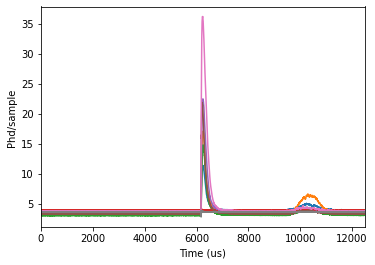

In [8]:
# plot - no baseline sub yet
i = 3
i_chan = 0
ch_labels=['A','B','C','D','E','F','G','H']
ch_colors=[pl.cm.tab10(ii) for ii in range(n_channels)]
fig = pl.figure(1,figsize=(10, 7))
pl.rc('xtick', labelsize=10)
pl.rc('ytick', labelsize=10)
ax = pl.subplot2grid((2,2),(0,0))
for i_chan in range(n_channels-1):
    #pl.plot(t_matrix[i,:],v_matrix_all_ch[i_chan][i,:],color=ch_colors[i_chan],label=ch_labels[i_chan])
    pl.plot( x,v_matrix_all_ch[i_chan][i,:],color=ch_colors[i_chan],label=ch_labels[i_chan])
pl.xlim([0.,wsize])
#pl.ylim([0, 16000])
pl.xlabel('Time (us)')
pl.ylabel('Phd/sample')

In [9]:
# perform baseline subtraction:

baseline_start = int(0./tscale)
baseline_end = int(2./tscale)

# baseline subtracted (bls) waveforms:
v_bls_matrix_all_ch = np.zeros( np.shape(v_matrix_all_ch) ) # (chan #, evt #, sample #)

print("Total events: ",v_matrix.shape[0])
for i in range(0, int(v_matrix.shape[0])):
    if i%100==0: print("Event #",i)
    
    sum_baseline = np.mean( v_matrix_all_ch[-1][i,baseline_start:baseline_end] ) #avg ~us, avoiding trigger
    baselines = [ np.mean( ch_j[i,baseline_start:baseline_end] ) for ch_j in v_matrix_all_ch ]
    
    #print( np.shape(baselines) )
    #print("baseline:", baselines)
    #print("sum baseline:", sum_baseline)
    sum_data = v_matrix_all_ch[-1][i,:] - sum_baseline
    ch_data = [ch_j[i,:]-baseline_j for (ch_j,baseline_j) in zip(v_matrix_all_ch,baselines)]
    
    v_bls_matrix_all_ch[:,i,:] = ch_data
        
    #print( np.shape(sum_data) )
    #print( np.shape(ch_data) )
print( np.shape(ch_data) )
print( np.shape(v_bls_matrix_all_ch) )

Total events:  244
Event # 0
Event # 100
Event # 200
(9, 12500)
(9, 244, 12500)


max at 12.197266


Text(0, 0.5, 'phd/sample')

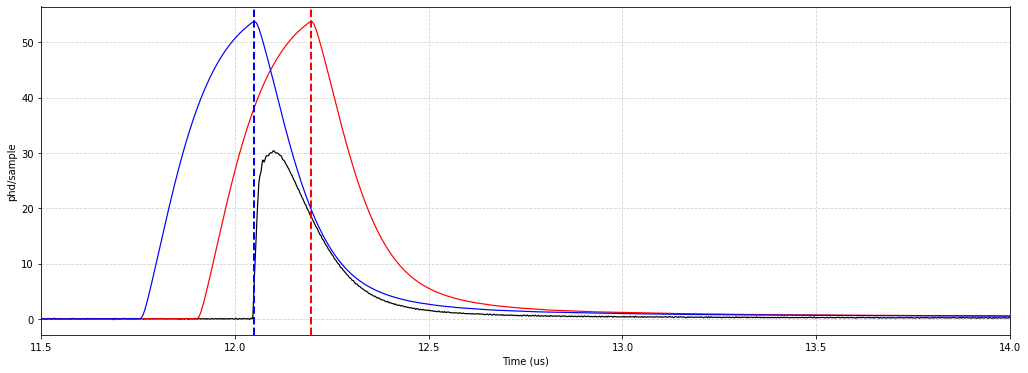

In [11]:
# plot the baseline sub data:
i = 8
i_chan = 0
ch_labels=['A','B','C','D','E','F','G','H']
ch_colors=[pl.cm.tab10(ii) for ii in range(n_channels)]
fig = pl.figure(1,figsize=(28, 10))
pl.rc('xtick', labelsize=10)
pl.rc('ytick', labelsize=10)
ax = pl.subplot2grid((2,2),(0,0))
pl.grid(b=True,which='major',color='lightgray',linestyle='--')
#for i_chan in range(n_channels-1):
#    pl.plot(t_matrix[i,:],v_bls_matrix_all_ch[i_chan,i,:],color=ch_colors[i_chan],label=ch_labels[i_chan])
pl.plot(t_matrix[i,:],v_bls_matrix_all_ch[-1,i,:],color='black',lw=1.2)

boxWidth = 150 # in samples

conv = wfm_convolve( v_bls_matrix_all_ch[-1,i,:] , boxWidth )
max_boxArea_sample = np.argmax(conv)
pl.plot(t_matrix[i,:],conv/50,color='red',lw=1.2)
print('max at {:f}'.format(max_boxArea_sample*tscale))
ax.axvline( max_boxArea_sample*tscale, alpha=1, color='red',linestyle='--',lw=2)

numSamples = len(v_bls_matrix_all_ch[-1,i,:])
boxAreaRolling = np.zeros(numSamples)
tmpBoxArea = 0
areaStepSize = 1 # higher can help improve speed of initial search
for t in range(0,numSamples-boxWidth-1,areaStepSize):
        tmpBoxArea = np.sum( v_bls_matrix_all_ch[-1,i,t:t+boxWidth] )
        boxAreaRolling[t] = tmpBoxArea

pl.plot(t_matrix[i,:],boxAreaRolling/50,color='blue',lw=1.2)
max_boxArea_sample = np.argmax(boxAreaRolling)
ax.axvline( max_boxArea_sample*tscale, alpha=1, color='blue',linestyle='--',lw=2)

pl.xlim([11.5,14.])
#pl.ylim([0, 16000])
pl.xlabel('Time (us)')
pl.ylabel('phd/sample')
#pl.legend()

In [ ]:
fig=pl.figure(1,figsize=(10, 7))
        pl.rc('xtick', labelsize=10)
        pl.rc('ytick', labelsize=10)
        
        ax=pl.subplot2grid((2,2),(0,0))
        pl.title("Top array, event "+str(i))
        pl.grid(b=True,which='major',color='lightgray',linestyle='--')
        ch_labels=['A','B','C','D','E','F','G','H']
        ch_colors=[pl.cm.tab10(ii) for ii in range(n_channels)]
        #ch_colors=[pl.cm.Dark2(ii) for ii in np.linspace(0.2,0.9,n_channels)]
        #ch_colors=['y','cyan','magenta','b','y','cyan','magenta','b']
        if s2_found:
            ax.axvspan(s2_start_pos*tscale, s2_end_pos*tscale, alpha=0.3, color='blue')
        if s1_found:
            ax.axvspan(s1_start_pos*tscale, s1_end_pos*tscale, alpha=0.3, color='green')
        for i_chan in range(n_channels-1):
            if i_chan == (n_channels-1)/2:
                ax=pl.subplot2grid((2,2),(0,1))
                pl.title("Bottom array, event "+str(i))
                pl.grid(b=True,which='major',color='lightgray',linestyle='--')
                
                if s2_found:
                    ax.axvspan(s2_start_pos*tscale, s2_end_pos*tscale, alpha=0.3, color='blue')
                if s1_found:
                    ax.axvspan(s1_start_pos*tscale, s1_end_pos*tscale, alpha=0.3, color='green')
            
            pl.plot(t_matrix[i,:],v_matrix_all_ch[i_chan][i,:],color=ch_colors[i_chan],label=ch_labels[i_chan])
            pl.xlim([trigger_time_us-8,trigger_time_us+8])
            pl.ylim([0, 1000/chA_spe_size])
            pl.xlabel('Time (us)')
            pl.ylabel('Phd/sample')
            pl.legend()
            #triggertime_us = (t[-1]*0.2)
            #pl.plot(np.array([1,1])*triggertime_us,np.array([0,16384]),'k--')
            

                    
        ax=pl.subplot2grid((2,2),(1,0),colspan=2)
        pl.plot(t_matrix[i,:],vsum_matrix[i,:],'blue')
        pl.xlim([0,25])
        pl.ylim([0, 4000/chA_spe_size])
        pl.xlabel('Time (us)')
        pl.ylabel('Phd/sample')
        pl.title("Sum, event "+ str(i))
        pl.grid(b=True,which='major',color='lightgray',linestyle='--')
        triggertime_us = (t[-1]*0.2)
        #pl.plot(np.array([1,1])*triggertime_us,np.array([0,16384]),'k--')
        if s2_found:
            ax.axvspan(s2_start_pos*tscale, s2_end_pos*tscale, alpha=0.3, color='blue')
        if s1_found:
            ax.axvspan(s1_start_pos*tscale, s1_end_pos*tscale, alpha=0.3, color='green')

In [54]:
numSamples=12500
boxWidth=1000

samps = list( range(0,numSamples-boxWidth-1,5) )

print( samps[-1] )

print( len( samps ) )
#for t in range(numSamples-boxWidth-1):
    

11495
2300
